# IPython Notebook for animation

## Importing the required libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from IPython.display import display, clear_output
import  matplotlib.animation as animation
import scipy.optimize as opt

In [2]:
from mcutils import *

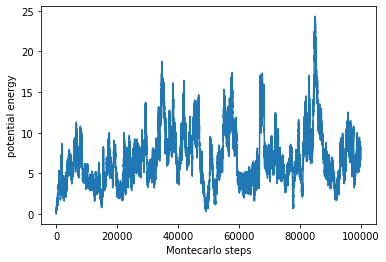

In [4]:
obsfilePath = 'outputs/out_M_48_P_50.txt'
obsData = importObsData(obsfilePath)
parameters = obsData[0]
obsData = obsData[1]
makePlot([obsData[0],obsData[1]], "potential energy")

In [4]:
print(parameters)

[['N', 'P', 'M', 'v0', 'beta', 'num_steps'], ['10', '50', '48', '2.000000e-01', '7.000000e-01', '1000']]


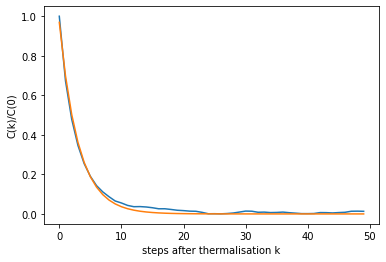

In [5]:
n_th = 100
noTherm = np.array(obsData[3][n_th:])
k_max = 50
autocorr_array = calc_autocorr(noTherm, k_max)
fitParams = fit_autocorr_time(autocorr_array, k_max)
tau_int = integrated_autocorr_time(autocorr_array)
makeFitPlot(autocorr_array, k_max, fitParams[0], fitParams[1])

In [15]:
beta = [0.1, 0.3, 0.5, 0.7]
B = [0., 0.01, 0.03]
obsfilePath_list = ['params_out/out'+str(st)+'.txt' for st in range(12)]
n_th_array = [10000 for i in range(12)]
m_arr = np.zeros((3,4))

observables = []

for i in range(3):
    for j in range(4):
        obsData = importObsData(obsfilePath_list[i*4+j])
        n_th = n_th_array[i*4+j]
        k_max = 500
        
        energyNoTherm = np.array(obsData[1][n_th:])
        energy_autocorr_array = calc_autocorr(energyNoTherm, k_max)
        energyFitParams = fit_autocorr_time(energy_autocorr_array, k_max)
        energy_tau_int = integrated_autocorr_time(energy_autocorr_array)
        
        magnNoTherm = np.array(obsData[2][n_th:])
        magn_autocorr_array = calc_autocorr(magnNoTherm, k_max)
        magnFitParams = fit_autocorr_time(magn_autocorr_array, k_max)
        magn_tau_int = integrated_autocorr_time(magn_autocorr_array)
        
        observables.append([np.mean(energyNoTherm),np.std(energyNoTherm),np.std(energyNoTherm)/np.sqrt(len(energyNoTherm)/(2*energyFitParams[1])),energyFitParams[1],np.mean(magnNoTherm),np.std(magnNoTherm),np.std(magnNoTherm)/np.sqrt(len(magnNoTherm)/(2*magnFitParams[1])),magnFitParams[1]])
        m_arr[i,j] = np.abs(np.mean(magnNoTherm))
        print(4*i+j)

/home/tim/code/MCising/mcutils.py:40: RuntimeWarning: overflow encountered in exp
  exp_fit = lambda x, a, tau : a*np.exp(-x/tau)
/home/tim/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


0
1
2
3
4
5
6
7
8
9
10
11


Text(0, 0.5, 'absolute magnetisation')

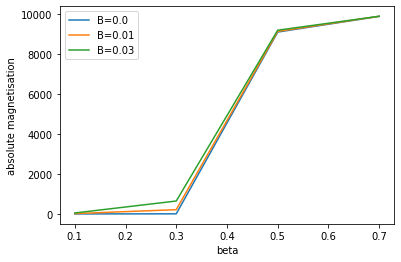

In [16]:
for i in range(len(B)):
    plt.plot(beta, m_arr[i,:], label=('B='+str(B[i])))
plt.legend()
plt.xlabel("beta")
plt.ylabel("absolute magnetisation")

From the plot above we can see that there is a phase transition around beta=0.4.
One can also see that even without a magnetic state, beta<0.3, with increasing external field
that the magnetisation increases.

In [15]:
file = open("observables_results.txt","w")
file.write("beta\tB\t<H>\tsigma(h)\terr(H)\ttau_H\t<M>\tsigma(M)\terr(M)\ttau_M\n")
for i in range(12):
    file.write("%e\t%e"%(beta[i%4],B[i//4]))
    for j in range(8):
        file.write("\t%e"%observables[i][j])
    file.write("\n")
file.close()

## Analytic Calculation of the Hamiltonian
$$H(s)=-\sum_{<xy>}s(x)s(y)-B\sum_x s(x)$$
1. system with all spins up s_1:\
The product $s(x)s(y)$ always takes a value 1 and there are N * D summands. The second sum has N summands which all add -B:
$H(s_1)=-N*D-N*B$
 
2. system with all spins down s_2:\
The product $s(x)s(y)$ always takes a value 1 and there are N * D summands. The second sum has N summands which all add +B:
$H(s_2)=-N*D+N*B$
 
3. system with alternating orientation of spins in index notation s_3:\
Every spin with an even index has a up position, every spin with a odd index has a down position. The next neighbours of spin with index i, s(i), are s(i+N^µ) with µ=0,...,D-1.\
case 1: N is even\
If N is even, every exponential N^µ is even, except for µ=0 where it is 1. So every product $s(x)s(y)$ except for µ=0 is a product between spins with even indeces or spins with odd indeces and is therefore 1, but the product with the next neighbour with µ=0 is -1. The first sum in $H(s)$ is therefore -N * (D-2). For even N there as many spin ups as there are spin downs and therefore the second sum equals zero:\
$H(s_3,N\ even)=-N*(D-2)$ \
case 2: N is odd\
If N is odd, every exponential N^µ is odd. So every product $s(x)s(y)$ is a product between two spins with one even index and one odd index is therefore -1. The first sum in $H(s)$ is therefore N * D. For odd N there is one more even index and therefore the second sum delivers -B:\
$H(s_3,N\ odd)=N*D-B$\
!!!! BUT odd N to not fullfill periodic boundary conditions !!!!

## Generate animation

In [ ]:
inputfilePath = 'config_output.txt'

plotData = importPlotData(inputfilePath)

fps = 5
nSeconds = int(len(plotData)/fps)

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure( figsize=(100,100) )

plotData = plotData.reshape(len(plotData),100,100)
im = plt.imshow(plotData[0], interpolation='none', aspect='auto', vmin=0, vmax=1)

def animate_func(i):
    if i % fps == 0:
        print( '.', end ='' )

    im.set_array(plotData[i])
    return [im]

anim = animation.FuncAnimation(fig, animate_func, frames = nSeconds * fps, interval = 1000 / fps)

anim.save('test_anim.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])

print('Done!')